In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re,glob,sys,collections

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Several years ago I extracted ~4k small molecule structures from the PDB for use in my internal conformer generation evaluation.  The goal is to find conformations that are close to the *bound* conformation from the PDB.  The results of this earlier conformer generation evaluation led to the parameterization of my `rdconfs.py` script (https://github.com/dkoes/rdkit-scripts/blob/master/rdconf.py).

Recently (May 2017) I decided to revisit the evaluation due to the new knowledge-based ETKDG (versus distance geomtry) algorithm in RDKit and improvements to the force fields.

I generated a maximum of 25 conformers for each ligand and then calculated the **best** rmsd of all generated conformers to the crystal pose:
```
~/git/rdkit-scripts/rdconf.py --maxconfs 25 combinedIndex.smi rdconfs2/rdconfs_nomin.sdf.gz --nomin >& rdconfs2/rdconfs_nomin.log
../rdcomparermsds.py rdconfs2/rdconfs_nomin.sdf.gz >& rdconfs2/rdconfs_nomin.rmsd
~/git/rdkit-scripts/rdconf.py --maxconfs 25 combinedIndex.smi rdconfs2/rdconfs_etkdg.sdf.gz --etkdg >& rdconfs2/rdconfs_etkdg.log
../rdcomparermsds.py rdconfs2/rdconfs_etkdg.sdf.gz >& rdconfs2/rdconfs_etkdg.rmsd
~/git/rdkit-scripts/rdconf.py --maxconfs 25 combinedIndex.smi rdconfs2/rdconfs_mmff.sdf.gz --mmff >& rdconfs2/rdconfs_mmff.log
../rdcomparermsds.py rdconfs2/rdconfs_mmff.sdf.gz >& rdconfs2/rdconfs_mmff.rmsd
~/git/rdkit-scripts/rdconf.py --maxconfs 25 combinedIndex.smi rdconfs2/rdconfs_etkdg_nomin.sdf.gz --etkdg --nomin >& rdconfs2/rdconfs_etkdg_nomin.log
../rdcomparermsds.py rdconfs2/rdconfs_etkdg_nomin.sdf.gz >& rdconfs2/rdconfs_etkdg_nomin.rmsd
~/git/rdkit-scripts/rdconf.py --maxconfs 25 combinedIndex.smi rdconfs2/rdconfs_etkdg_mmff.sdf.gz --etkdg --mmff >& rdconfs2/rdconfs_etkdg_mmff.log
../rdcomparermsds.py rdconfs2/rdconfs_etkdg_mmff.sdf.gz >& rdconfs2/rdconfs_etkdg_mmff.rmsd
~/git/rdkit-scripts/rdconf.py --maxconfs 25 combinedIndex.smi rdconfs2/rdconfs_default.sdf.gz  >& rdconfs2/rdconfs_default.log
../rdcomparermsds.py rdconfs2/rdconfs_default.sdf.gz >& rdconfs2/rdconfs_default.rmsd
```

*After Greg Landrum pointed out that the benefit of ETKDG is that it should require fewer conformers to sample a good pose, I re-ran the above with a max of 5 conformers.*

Here's the code for `rdcomparermsds.py`:

In [ ]:
from rdkit.Chem import AllChem as Chem

infile = sys.argv[1]
if infile.endswith('.gz'):
  input = gzip.open(infile)
else:
  input = open(infile)

vals = dict()
for mol in Chem.ForwardSDMolSupplier(input):
	try:
		title = mol.GetProp("_Name");
		titletoks = title.split()
		weight = titletoks[0]
		natoms = titletoks[1]
		nrot = titletoks[2]
		files = titletoks[3:]
		minrmsd = 100
		for file in files:
			for ref in Chem.SDMolSupplier(file):
				rms = Chem.GetBestRMS(mol,ref)
				if rms < minrmsd:
					minrmsd = rms
		if title not in vals:
			vals[title] = minrmsd
		elif vals[title] > minrmsd:
			vals[title] = minrmsd
	except:
		pass
for x in sorted(vals.keys()):
	print vals[x],x

Not all the methods were equally successfull at generating conformations:

In [2]:
!wc rdconfs2/*.rmsd

    4262   21310  265476 rdconfs2/rdconfs5_default.rmsd
    4263   21315  265555 rdconfs2/rdconfs5_etkdg.rmsd
    4220   21100  262754 rdconfs2/rdconfs5_etkdg_mmff.rmsd
    4264   21320  265550 rdconfs2/rdconfs5_etkdg_nomin.rmsd
    4219   21095  262659 rdconfs2/rdconfs5_mmff.rmsd
    4263   21315  265038 rdconfs2/rdconfs5_nomin.rmsd
    4262   21310  266079 rdconfs2/rdconfs_default.rmsd
    4263   21315  266234 rdconfs2/rdconfs_etkdg.rmsd
    4220   21100  263316 rdconfs2/rdconfs_etkdg_mmff.rmsd
    4264   21320  265921 rdconfs2/rdconfs_etkdg_nomin.rmsd
    4219   21095  263229 rdconfs2/rdconfs_mmff.rmsd
    4263   21315  265331 rdconfs2/rdconfs_nomin.rmsd
   50982  254910 3177142 total


In [3]:
def collate(g):
    # extract data from rmsd files (I'm sure this could be written in a few lines of pandas - but it's faster for me to write it this way)
    data = []
    namecnt = collections.defaultdict(int)
    for f in glob.glob(g):
        name = re.findall(r'.*rdconfs\d?_(\S+)\.rmsd',f)[0]
        for line in open(f):
            (rmsd, weight,natoms,nrot,cmpd) = line.split()
            data.append([name,float(rmsd), int((float(nrot))), cmpd])
            namecnt[cmpd] += 1

    #collect rmsds of only cmpds that are present in all files binned by nrot
    rmsds = dict()
    allrmsds = dict()
    for (name, rmsd, nrot, cmpd) in data:
        if namecnt[cmpd] >= 6:
            if name not in rmsds:
                rmsds[name] = [[] for x in xrange(26)]
                allrmsds[name] = []
            if nrot > 25:
                nrot = 25 #combine             
            rmsds[name][nrot].append(rmsd)
            allrmsds[name].append(rmsd)

    #now statistics
    aves = dict()
    stds = dict()
    for name in rmsds.keys():
        aves[name] = [np.mean(vals) for vals in rmsds[name]]
        stds[name] = [np.std(vals) for vals in rmsds[name]]
        
    return (allrmsds,rmsds,aves,stds)

(allrmsds,rmsds,aves,stds) = collate('rdconfs2/rdconfs_*.rmsd')
(allrmsds5,rmsds5,aves5,stds5) = collate('rdconfs2/rdconfs5_*.rmsd')

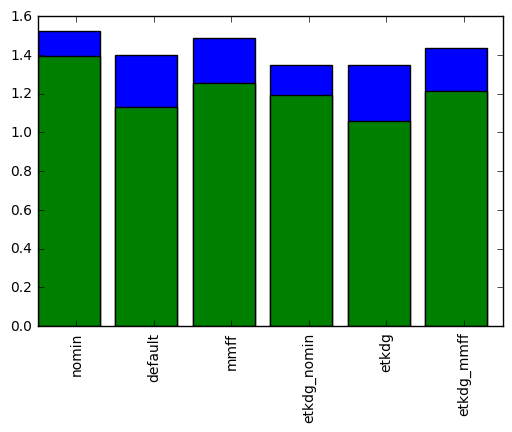

In [4]:
ticks = np.arange(0,6)
keys = ['nomin','default','mmff','etkdg_nomin','etkdg','etkdg_mmff']
plt.bar(ticks, [np.mean(allrmsds5[k]) for k in keys])
plt.bar(ticks, [np.mean(allrmsds[k]) for k in keys],color='g')
plt.xticks(ticks+0.5,rotation='vertical')
plt.gca().set_xticklabels(keys);

MMFF remains a bad idea - worse than not minimizing (it's also slow).  ETKDG is better both before and after minimization (but not by a whole lot).

Unsurprisingly, sampling more conformers lowers the best RMSD (mathematically it has to be <=).  Qualitatively, I don't see the ETKDG improvement to be more than that seen with 25 conformers.

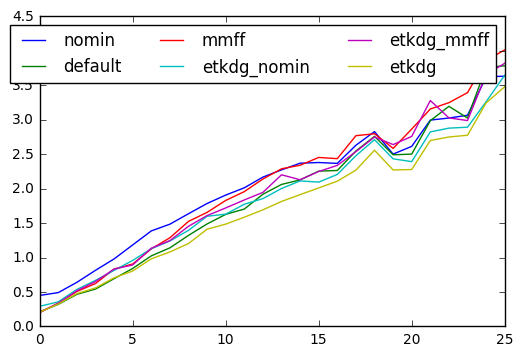

In [5]:
for n in allrmsds:
    plt.plot(aves[n],label=n)
    
plt.legend(ncol=3)

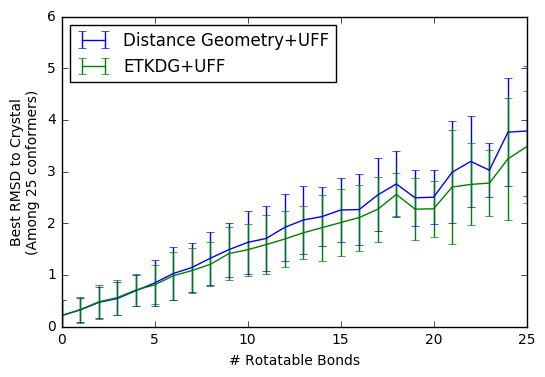

In [6]:
plt.errorbar(xrange(26),aves['default'],label='Distance Geometry+UFF',yerr=stds['default'])
plt.errorbar(xrange(26),aves['etkdg'],label='ETKDG+UFF',yerr=stds['etkdg'])
plt.xlabel("# Rotatable Bonds")
plt.ylabel("Best RMSD to Crystal\n(Among 25 conformers)")
plt.ylim(0,6)
plt.legend(loc='best');

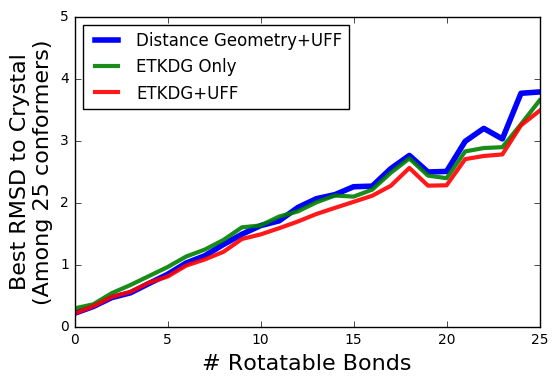

In [7]:
plt.plot(xrange(26),aves['default'],label='Distance Geometry+UFF',linewidth=4)
plt.plot(xrange(26),aves['etkdg_nomin'],label='ETKDG Only',linewidth=3,alpha=.9)
plt.plot(xrange(26),aves['etkdg'],label='ETKDG+UFF',linewidth=3,alpha=.9)


plt.xlabel("# Rotatable Bonds",fontsize=16)
plt.ylabel("Best RMSD to Crystal\n(Among 25 conformers)",fontsize=16)
plt.ylim(0,5)
plt.legend(loc='best');

<Container object of 26 artists>

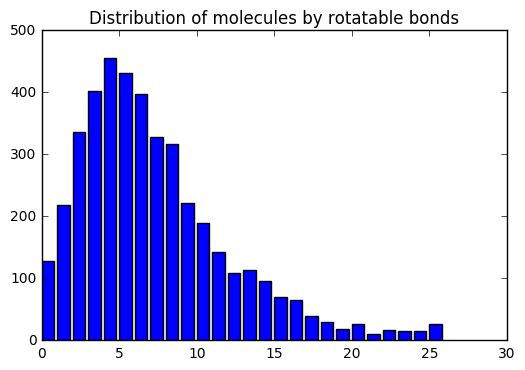

In [8]:
plt.title("Distribution of molecules by rotatable bonds")
plt.bar(xrange(26),[len(x) for x in rmsds['default']])

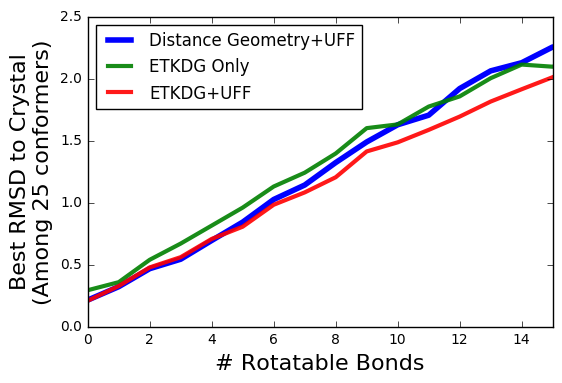

In [9]:
plt.plot(xrange(26),aves['default'],label='Distance Geometry+UFF',linewidth=4)
plt.plot(xrange(26),aves['etkdg_nomin'],label='ETKDG Only',linewidth=3,alpha=.9)
plt.plot(xrange(26),aves['etkdg'],label='ETKDG+UFF',linewidth=3,alpha=.9)


plt.xlabel("# Rotatable Bonds",fontsize=16)
plt.ylabel("Best RMSD to Crystal\n(Among 25 conformers)",fontsize=16)
plt.ylim(0,2.5)
plt.xlim(0,15)
plt.legend(loc='best');
plt.savefig('confeval.png',bbox_inches='tight')

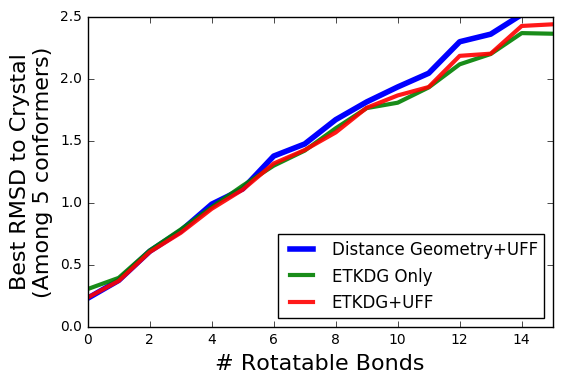

In [10]:
plt.plot(xrange(26),aves5['default'],label='Distance Geometry+UFF',linewidth=4)
plt.plot(xrange(26),aves5['etkdg_nomin'],label='ETKDG Only',linewidth=3,alpha=.9)
plt.plot(xrange(26),aves5['etkdg'],label='ETKDG+UFF',linewidth=3,alpha=.9)


plt.xlabel("# Rotatable Bonds",fontsize=16)
plt.ylabel("Best RMSD to Crystal\n(Among 5 conformers)",fontsize=16)
plt.ylim(0,2.5)
plt.xlim(0,15)
plt.legend(loc='best');
plt.savefig('confeval5.png',bbox_inches='tight')

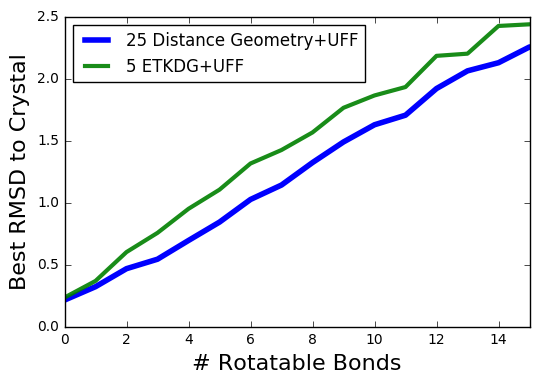

In [11]:
plt.plot(xrange(26),aves['default'],label='25 Distance Geometry+UFF',linewidth=4)
plt.plot(xrange(26),aves5['etkdg'],label='5 ETKDG+UFF',linewidth=3,alpha=.9)

plt.xlabel("# Rotatable Bonds",fontsize=16)
plt.ylabel("Best RMSD to Crystal",fontsize=16)
plt.ylim(0,2.5)
plt.xlim(0,15)
plt.legend(loc='best');


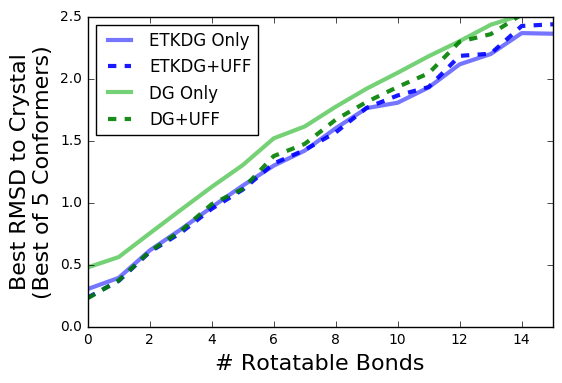

In [35]:
plt.plot(xrange(26),aves5['etkdg_nomin'],color='#6666ff',label='ETKDG Only',linewidth=3,alpha=.9)
plt.plot(xrange(26),aves5['etkdg'],'b--',label='ETKDG+UFF',linewidth=3,alpha=.9)
plt.plot(xrange(26),aves5['nomin'],color='#66cc66',label='DG Only',linewidth=3,alpha=.9)
plt.plot(xrange(26),aves5['default'],'g--',label='DG+UFF',linewidth=3,alpha=.9)

plt.xlabel("# Rotatable Bonds",fontsize=16)
plt.ylabel("Best RMSD to Crystal\n(Best of 5 Conformers)",fontsize=16)
plt.ylim(0,2.5)
plt.xlim(0,15)
plt.legend(loc='best');
plt.savefig('nomincomp.png',bbox_inches='tight')